# 9 Downstream analysis

### Define global variables

In [1]:
## -------------------------------------------DEFINE GLOBALS----------------------------------------
EMBEDDING_SPACE = 'MMAE_embedding' # maui_embedding_3
PROJECTION_DATA = 'MMAE_clustering_270' # all_data_MAUI_clustering_240_NEW

In [2]:
import re

def reorderDrugs(l_col):
    new_col = []
    l_order = [ 'ETA', 'ADA', 'INF', 'CERTO', 'GOL', 'ABA', 'TCZ', 'ANA', 'RTX', 'BARI', 'TOFA', 'GOUD', 'MTX', 'SSZ', 'HQL', 'LEF', 'AZA', 'CYCLOFOSFAMIDE', 'CICLOSPORINE'] 
    
    
    for d_cur in l_col:
        l_drug = d_cur.split(' & ')
        l_weights = [l_order.index(i) for i in l_drug]
        l_drug = [x for _, x in sorted(zip(l_weights, l_drug))]
        new_col.append(' & '.join(l_drug))
    return new_col

def sortDrugs(l_col):
    l_order = ['MTX', 'SSZ', 'HQL', 'LEF', 'AZA', 'ETA', 'ADA', 'INF', 'CERTO', 'GOL', 'ABA', 'TCZ', 'ANA', 'RTX', 'BARI', 'TOFA', 'GOUD', 'CICLOSPORINE']  # 'MTX',
    l_dmard = ['MTX', 'SSZ', 'HQL', 'LEF', 'AZA'] # Move the conventional dmards to the end
    
    new_col = []
    
    for drug in l_order: # [::-1]
        if drug in l_col: # only if drug exists as solo 
            new_col.append(drug)
        for d_cur in l_col:
            l_drug = d_cur.split(' & ')
            # Extract DMARD -> and put it as last
            
            if d_cur not in new_col and drug in d_cur and drug != d_cur:
                if drug not in l_dmard:
                    new_col.append(d_cur) # add automatically
                elif len([drug for drug in l_drug if drug in l_dmard]) == len(l_drug):
                    new_col.append(d_cur)
                    print([drug for drug in l_drug if drug in l_dmard], l_drug)
    
    return new_col#[::-1]

## #1 Export all raw features

In [ ]:
import pandas as pd

# Import all independent variables
df_categoric= pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/5_clustering/df_categoric.csv', sep=',')
df_numeric = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/5_clustering/df_lab_raw_demographics.csv', sep=',')[['Leuko', 'MCH', 'Hb', 'Ht', 'MCHC',  'MCV', 'Trom', 'BSE',  'Age', 'pseudoId']]

def strip_right(df, suffix='_positive'):
    df.columns = df.columns.str.replace(suffix+'$', '', regex=True)

l_num = list(df_numeric.columns)

# Categorical data
l_cat = list(df_categoric.columns)
l_cat = [col for col in l_cat if 'negative' not in col]
l_cat = [i for i in l_cat if i not in ['Physician']] 

## Merge Categorical + Numerical
df_imp = df_categoric[l_cat].merge(df_numeric, left_on='pseudoId', right_on='pseudoId')
strip_right(df_imp) 

# Add pseudoIds
df_imp['pseudoId'] = pd.read_csv(r'../new_data/3_wide/DF_Lab_wide_Final2.csv', sep='|')['pseudoId']

# Export scaled table
df_imp.to_csv('../new_data/offshoots/df_ehr_raw.csv', sep='|', index=False)

df_imp.head()

## #2 Export scaled features

In [4]:
import pandas as pd

# Import all independent variables
df_categoric= pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/5_clustering/df_categoric.csv', sep=',')
df_numeric = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/5_clustering/df_lab_scaled_demographics.csv', sep=',')[['pseudoId','Leuko', 'MCH', 'Hb', 'Ht', 'MCHC',  'MCV', 'Trom', 'BSE', 'Age']]

In [ ]:
l_num = list(df_numeric.columns)

# Categorical data
l_cat = list(df_categoric.columns)
#l_cat = [col for col in l_cat if 'negative' not in col]
l_cat = [i for i in l_cat if i not in ['PHYSICIAN']] 

## Merge Categorical + Numerical
df_imp = df_categoric[l_cat].merge(df_numeric, left_on='pseudoId', right_on='pseudoId')

# Export scaled table
df_imp.to_csv('../new_data/offshoots/df_ehr_scaled.csv', sep='|', index=False)

df_imp.head()

#### Add dependent variable/outcome

In [ ]:
import pandas as pd

df_imp = pd.read_csv('../new_data/offshoots/df_ehr_scaled.csv', sep='|')
df_meta = pd.read_csv('../new_data/7_final/MMAE_clustering_270.csv')[['pseudoId','Physician', 'DAS44', 'DAS28(3)', 'PhenoGraph_clusters']]
df_meta = df_meta.merge(df_imp, on='pseudoId', how='left')
df_meta

#### Add latent factors and Physician information

In [ ]:
import pandas as pd
EMBEDDING_SPACE = 'MMAE_embedding' # maui_embedding_3
Z = pd.read_csv('../results/embedding/%s.csv' % EMBEDDING_SPACE) # maui_embedding_2.csv
Z

In [9]:
Z = pd.read_csv('../results/embedding/%s.csv' % EMBEDDING_SPACE) # maui_embedding_2.csv
Z = Z[Z.columns[4:]]
df_ult = df_meta.merge(Z, left_index=True, right_index=True)


df_info = pd.read_csv(r'../new_data/7_final/MMAE_clustering_270_Stability.csv', sep=',')
d_cluster1 = dict(zip(df_info.pseudoId, df_info.PROBA_CLUSTER0))
d_cluster2 = dict(zip(df_info.pseudoId, df_info.PROBA_CLUSTER1))
d_cluster3 = dict(zip(df_info.pseudoId, df_info.PROBA_CLUSTER2))
d_cluster4 = dict(zip(df_info.pseudoId, df_info.PROBA_CLUSTER3))
df_ult['PROBA_CLUSTER1'] = df_ult['pseudoId'].apply(lambda x: d_cluster1[x])
df_ult['PROBA_CLUSTER2'] = df_ult['pseudoId'].apply(lambda x: d_cluster2[x])
df_ult['PROBA_CLUSTER3'] = df_ult['pseudoId'].apply(lambda x: d_cluster3[x])
df_ult['PROBA_CLUSTER4'] = df_ult['pseudoId'].apply(lambda x: d_cluster4[x])

df_response = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/7_final/SummaryResponseTable_MMAE_wOutcome.csv', sep=',', index_col=0)
df_ult = pd.merge(df_ult, df_response, left_on='pseudoId', right_on='pseudoId')

## ADD FEET & HAND Joint count
df_feethand = pd.read_csv('../filters/RA_patients_AllNP_Characteristics_symptomDur.csv', sep='|') # all_data_MMAE_clustering_240_NEW all_data_MAUI_clustering_240_NEW.csv
d_feet = dict(zip(df_feethand['pseudoId'], df_feethand['FEET-count'])) 
d_hand = dict(zip(df_feethand['pseudoId'], df_feethand['HAND-count']))

df_cluster = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/7_final/MMAE_clustering_270.csv') 
df_ult['FEETcount'] = df_cluster['pseudoId'].apply(lambda x : d_feet[x])
df_ult['HANDcount'] = df_cluster['pseudoId'].apply(lambda x : d_hand[x])

df_ult.to_csv('../new_data/offshoots/df_ehr_scaled_withOutcome_woCounts.csv', sep='|', index=False)

In [ ]:
df_info = pd.read_csv(r'../new_data/7_final/MMAE_clustering_270_Stability.csv', sep=',')

# import appointments 
df_viral = pd.read_csv(r'../../new_data/offshoots/ParvoVirus/DF_parvovirus.csv', sep=";") # Appointments_REU.csv
len(df_viral['subject_Patient_value'].unique())


### #2.1 Heatmap - check how consistent patients cocluster with eachother!

,PhenoGraph_iter_5,PhenoGraph_iter_7,PhenoGraph_iter_9,PhenoGraph_iter_12,PhenoGraph_iter_14,PhenoGraph_iter_15,PhenoGraph_iter_16,PhenoGraph_iter_18,PhenoGraph_iter_20,PhenoGraph_iter_21,...,PhenoGraph_iter_1488,PhenoGraph_iter_1489,PhenoGraph_iter_1490,PhenoGraph_iter_1491,PhenoGraph_iter_1492,PhenoGraph_iter_1494,PhenoGraph_iter_1495,PhenoGraph_iter_1496,PhenoGraph_iter_1497,PhenoGraph_iter_1499
0,0.0,NaN,NaN,NaN,1.0,2.0,0.0,NaN,NaN,NaN,...,0.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,NaN,0.0
651,2.0,1.0,0.0,0.0,1.0,NaN,0.0,1.0,NaN,NaN,...,0.0,NaN,1.0,NaN,NaN,0.0,NaN,1.0,0.0,0.0
653,2.0,1.0,0.0,0.0,NaN,2.0,0.0,1.0,1.0,NaN,...,0.0,1.0,1.0,0.0,NaN,0.0,NaN,NaN,NaN,0.0
654,2.0,1.0,0.0,0.0,1.0,NaN,NaN,1.0,1.0,0.0,...,0.0,1.0,1.0,NaN,0.0,0.0,1.0,1.0,NaN,0.0
656,1.0,1.0,0.0,NaN,1.0,2.0,NaN,1.0,NaN,0.0,...,NaN,1.0,1.0,NaN,0.0,0.0,1.0,1.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
453,1.0,2.0,3.0,NaN,2.0,NaN,NaN,3.0,2.0,3.0,...,3.0,1.0,NaN,NaN,3.0,NaN,3.0,NaN,NaN,2.0
233,NaN,NaN,3.0,3.0,NaN,1.0,3.0,3.0,NaN,NaN,...,3.0,3.0,3.0,2.0,3.0,NaN,3.0,NaN,3.0,NaN
282,NaN,2.0,NaN,3.0,NaN,NaN,3.0,3.0,NaN,NaN,...,NaN,3.0,3.0,2.0,3.0,3.0,3.0,3.0,3.0,NaN
1096,1.0,2.0,3.0,3.0,NaN,1.0,NaN,3.0,2.0,NaN,...,3.0,NaN,NaN,NaN,3.0,3.0,3.0,3.0,NaN,NaN


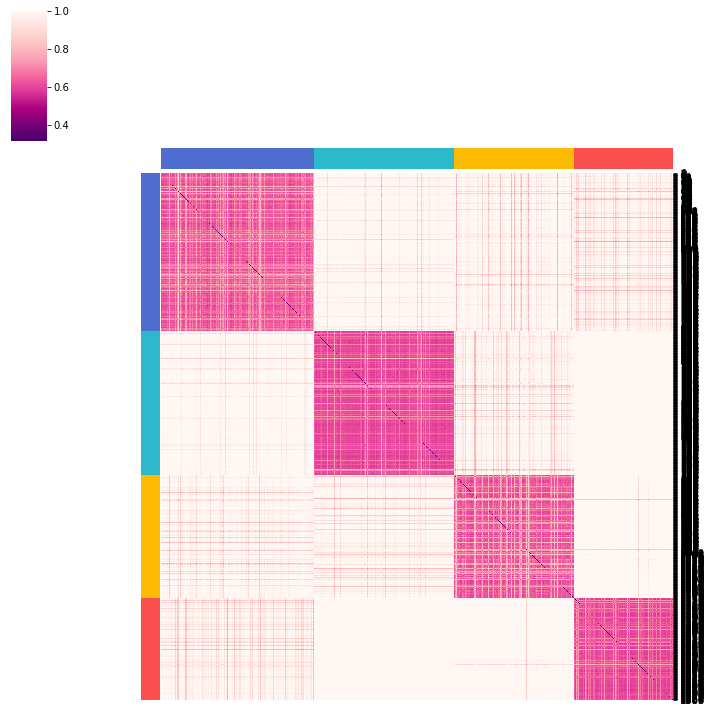

In [1]:
import pandas as pd
from scipy.spatial.distance import cdist
import seaborn as sns

df_info = pd.read_csv(r'../new_data/7_final/MMAE_clustering_270_Stability.csv', sep=',')
l_cols = [col for col in df_info.columns if 'PhenoGraph_iter_' in col]
df_info= df_info.sort_values(by='PhenoGraph_clusters')

# '#4F6CCF', '#2db9cc', '#fcba03', '#FA4D4D',
lut = {0: '#4F6CCF', 1 : '#2db9cc', 2: '#fcba03', 3: '#FA4D4D'}
A_colors = pd.Series(df_info['PhenoGraph_clusters']).map(lut)
B_colors = pd.Series(df_info['PhenoGraph_clusters']).map(lut)

# Within cluster distance -> vs 
dist = cdist(df_info[l_cols], df_info[l_cols],'matching') # jaccard , ''
g = sns.clustermap(dist,

                  # Turn off the clustering
                  row_cluster=False, col_cluster=False,

                  # Add colored class labels # col_colors=cluster_colors,
                   cmap="RdPu_r",   # vmax=5 ,  vmax=1 ,  vmin=0, RdPu_r

                  # Make the plot look better when many rows/cols
                  linewidths=0, xticklabels=False, yticklabels=True, row_colors=list(A_colors.values)
                                                                                     , col_colors=list(A_colors.values)) # , cmap="PiYG")
df_info[l_cols]

## #3 Visualize physicians per cluster
We clearly observe that there are no clusters that are fully based on physicians

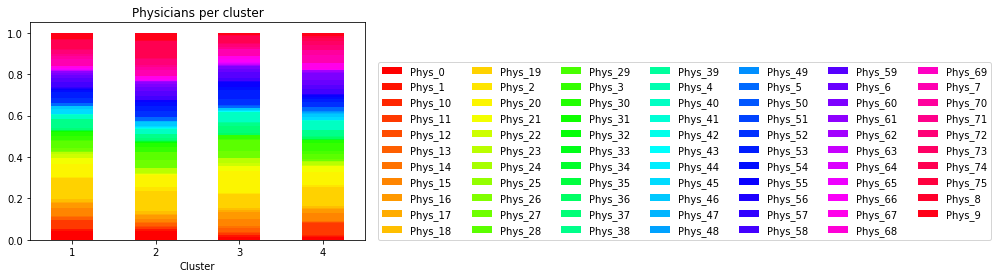

In [13]:
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import pandas as pd

# Import data
df_ult = pd.read_csv('../new_data/offshoots/df_ehr_scaled_withOutcome_woCounts.csv', sep='|')
df_ult['Physician'] = df_ult['Physician'].astype(str)
df_ult['Cluster'] = df_ult['PhenoGraph_clusters']  + 1#.astype(str)

# Anonymize phyisicians
d_anonym = {}
for i, physician in enumerate(sorted(list(df_ult['Physician'].unique()))):
    d_anonym[physician] = 'Phys_%s' % i
df_ult['Physician'] = df_ult['Physician'].apply(lambda x : d_anonym[x])

# Count unique physicians per cluster
df_agg = df_ult.groupby(['Cluster'])['Physician'].value_counts(normalize=True).unstack().fillna(0)

# Create Palette
rainbow = cm.get_cmap('hsv', 80)
newcolors = rainbow(np.linspace(0, 1, 80))
newcmp = ListedColormap(newcolors)

# Very simple one-liner using our agg_tips DataFrame.
df_agg.plot(kind='bar', stacked=True, cmap=newcmp)

# Just add a title and rotate the x-axis labels to be horizontal.
plt.title('Physicians per cluster')
plt.xticks(rotation=0, ha='center')
plt.legend(loc=(1.04,0), ncol= 7)

## #4 Look at exposure rates (how often do the clusters receive certain drugs)

['MTX', 'AZA'] ['MTX', 'AZA']
['MTX', 'SSZ', 'AZA'] ['MTX', 'SSZ', 'AZA']
['MTX', 'HQL', 'LEF'] ['MTX', 'HQL', 'LEF']
['MTX', 'SSZ', 'HQL', 'LEF'] ['MTX', 'SSZ', 'HQL', 'LEF']
['MTX', 'HQL'] ['MTX', 'HQL']
['MTX', 'SSZ', 'HQL'] ['MTX', 'SSZ', 'HQL']
['MTX', 'LEF'] ['MTX', 'LEF']
['MTX', 'SSZ', 'LEF'] ['MTX', 'SSZ', 'LEF']
['MTX', 'SSZ'] ['MTX', 'SSZ']
['SSZ', 'HQL', 'LEF'] ['SSZ', 'HQL', 'LEF']
['SSZ', 'HQL'] ['SSZ', 'HQL']
['SSZ', 'LEF'] ['SSZ', 'LEF']
['HQL', 'AZA'] ['HQL', 'AZA']
['HQL', 'LEF', 'AZA'] ['HQL', 'LEF', 'AZA']
['HQL', 'LEF'] ['HQL', 'LEF']
['LEF', 'AZA'] ['LEF', 'AZA']


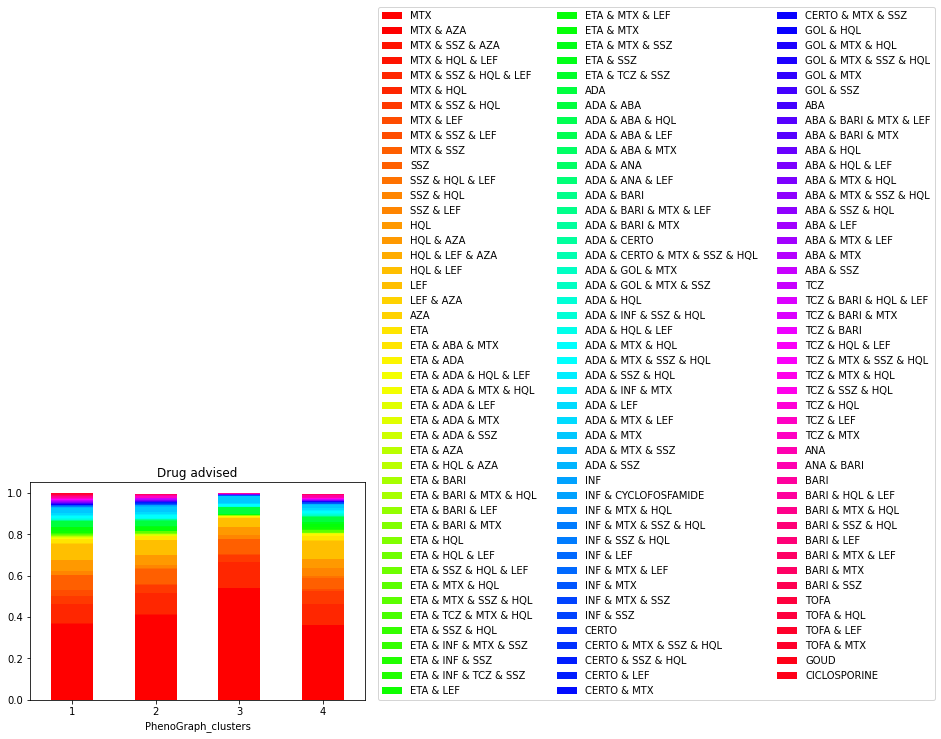

In [10]:
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import pandas as pd

d_acronym = {'ABATACEPT' : 'ABA', 'ADALIMUMAB' : 'ADA', 'ANAKINRA' : 'ANA', 'AZATHIOPRINE' : 'AZA','AUROTHIOBARNSTEENZUUR (DI-NA-ZOUT)' : 'GOUD', 'BARICITINIB': 'BARI', 'CERTOLIZUMAB PEGOL' :'CERTO',  'ETANERCEPT' : 'ETA', 'GOLIMUMAB' : 'GOL', 'HYDROXYCHLOROQUINE':'HQL', 'INFLIXIMAB' : 'INF', 'LEFLUNOMIDE' : 'LEF', 'METHOTREXAAT' : 'MTX', 'RITUXIMAB' : 'RTX', 'SULFASALAZINE' : 'SSZ', 'TOCILIZUMAB' : 'TCZ', 'TOFACITINIB' : 'TOFA'}

df_drug = pd.read_csv('../new_data/7_final/DrugInformation.csv', sep=',')

df_cluster = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/7_final/MMAE_clustering_270_Stability.csv') #  all_data_MAUI_clustering_240_Stability

df_cluster['pseudoId'] = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/5_clustering/df_metadata_keys.csv')['pseudoId']
df_cluster['PhenoGraph_clusters'] = df_cluster['PhenoGraph_clusters'] +1
# Add the actual patient id & pseudoId to the metadata (by matching on the index)
df_drug = pd.merge(df_drug, df_cluster[['pseudoId', 'PhenoGraph_clusters']], on='pseudoId')


df_response = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/7_final/SummaryResponseTable_MMAE3.csv', sep=';')
df_drug = pd.merge(df_drug, df_response, left_on='pseudoId', right_on='pseudoId')

df_drug['Drug'] = df_drug['Drug'].apply(lambda x : ' & '.join([d_acronym[i]  if i in d_acronym.keys() else i for i in sorted(x.split(' & '))]))

# Only select those where they stay on a drug longer than a year
df_drug['Time'] = df_drug['Time'].astype(float)
df_relevant = df_drug[df_drug['MTX-starter']==True]

# Create Palette
rainbow = cm.get_cmap('hsv', 80)
newcolors = rainbow(np.linspace(0, 1, 80))
newcmp = ListedColormap(newcolors)


df_agg = df_relevant.groupby(['PhenoGraph_clusters'])['Drug'].value_counts(normalize=True).unstack().fillna(0)

# Very simple one-liner using our agg_tips DataFrame.
df_agg.columns = reorderDrugs(list(df_agg.columns))

df_agg[sortDrugs(list(df_agg.columns))].plot(kind='bar', stacked=True, cmap=newcmp)

# Just add a title and rotate the x-axis labels to be horizontal.
plt.title('Drug advised')
plt.xticks(rotation=0, ha='center')
plt.legend(loc=(1.04,0), ncol= 3)


### #4.1 Are the clusters exposed to different drugs?
First, we create new dataframe to ensure we don't count people with multiple prescriptions of the same drug twice.  
Next, we compare the likelihood of clusters receiving biological- vs conventional DMARDs

In [11]:
# Create new dataframe to ensure we don't count people with multiple prescriptions of the same drug twice

df_patientBased = pd.DataFrame(columns=['pseudoId', 'All_prescriptions', 'PhenoGraph_clusters', 'MTX-starter'])
    
for pid in df_relevant['pseudoId'].unique():
    sub_df = df_relevant[df_relevant['pseudoId']==pid].copy()
    l_str = ' + '.join(list(sub_df['Drug']))
    df_patientBased.loc[len(df_patientBased)] = [sub_df['pseudoId'].iloc[0], l_str, sub_df['PhenoGraph_clusters'].iloc[0], sub_df['MTX-starter'].iloc[0]]
#df_patientBased

PhenoGraph_clusters  Biological
1                    0             273
                     1              77
2                    0             215
                     1              55
3                    0             217
                     1              21
4                    0             168
                     1              48
Name: Biological, dtype: int64


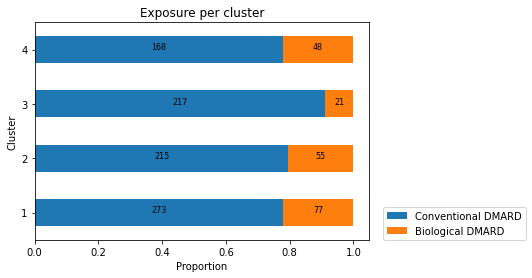

In [66]:
def isDrugTried(row, drug='ETA'): # ETA & ADA
    # if we find just one biological -> return True
    if row['All_prescriptions'] == row['All_prescriptions']: # check if not nan
        if drug in row['All_prescriptions']:       
            return 1
        else : 
            return 0
    else :
        return np.nan # return nan

def isBiological(row):
    l_biological = ['ETA', 'ADA', 'INF', 'CERTO', 'GOL', 'ABA', 'TCZ', 'RTX', 'BARI', 'TOFA', 'GOUD']
    biological = 0
    # if we find just one biological -> return True
    if row['All_prescriptions'] == row['All_prescriptions']: # check if not nan
        for drug in l_biological:
            if drug in row['All_prescriptions']:
                biological = 1
                break    
        return biological
    else :
        return np.nan # return nan

    
df_patientBased['Biological'] = df_patientBased.apply(lambda x : isBiological(x), axis=1)
df_patientBased['Exposed_to_ETA'] = df_patientBased.apply(lambda x : isDrugTried(x, drug='ETA'), axis=1)
df_patientBased['Exposed_to_ADA'] = df_patientBased.apply(lambda x : isDrugTried(x, drug='ADA'), axis=1)
df_patientBased = df_patientBased[df_patientBased['MTX-starter']==1].copy()

# Create list of patients that were exposed by a biological drug
d_exposed = dict(zip(df_patientBased.pseudoId, df_patientBased.Biological))
d_exposed_ETA = dict(zip(df_patientBased.pseudoId, df_patientBased.Exposed_to_ETA))
d_exposed_ADA = dict(zip(df_patientBased.pseudoId, df_patientBased.Exposed_to_ADA))

drug_name = 'Biological'

# Count unique physicians per cluster
df_drug_agg = df_patientBased.groupby(['PhenoGraph_clusters'])[drug_name].value_counts(normalize=True).unstack().fillna(0)

# Also create one with raw quantities
df_drug_quant = df_patientBased.groupby(['PhenoGraph_clusters'])[drug_name].value_counts(normalize=False).unstack().fillna(0)  

# Create Palette
rainbow = cm.get_cmap('hsv', 80)
newcolors = rainbow(np.linspace(0, 1, 80))
newcmp = ListedColormap(newcolors)

# Very simple one-liner using our agg_tips DataFrame.
df_drug_agg.plot(
kind = 'barh',
stacked = True,
title = 'Exposure per cluster',
mark_right = True,
xlabel = 'Proportion',
ylabel = 'Cluster') 

# Just add a title and rotate the x-axis labels to be horizontal.
plt.xticks(rotation=0, ha='center')
#plt.legend(['Conventional DMARD','Biological'], loc=(1.04,0), ncol= 3)

for n in df_drug_agg:
    for i, (cs, pc) in enumerate(zip(df_drug_agg.iloc[:, 0:].cumsum(1)[n],df_drug_agg[n])):
        (cs2, q) = list(zip(df_drug_quant.iloc[:, 0:].cumsum(1)[n],df_drug_quant[n]))[i]
        if np.round(pc * 100, 1) > 5: # Threshold = 5%
            plt.text(cs - pc / 2, i,  str(q),
                ha = 'center', rotation = 0, fontsize = 8)
plt.legend(['Conventional DMARD','Biological DMARD'],loc=(1.04,0), ncol= 1)
print(df_patientBased.groupby(['PhenoGraph_clusters'])[drug_name].value_counts(normalize=False))    

df_patientBased.groupby(['PhenoGraph_clusters'])[drug_name].value_counts(normalize=False).to_csv('../new_data/6_medication/Summary_Drug_Exposure.csv')

In [13]:
df_drug_agg

Biological,0,1
PhenoGraph_clusters,,
1,0.780000,0.220000
2,0.796296,0.203704
3,0.911765,0.088235
4,0.777778,0.222222


### #4.2 Success rates of conventional- and biological DMARDs

In [14]:
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import pandas as pd
import plotly.graph_objects as go

d_acronym = {'ABATACEPT' : 'ABA', 'ADALIMUMAB' : 'ADA', 'AZATHIOPRINE' : 'AZA','AUROTHIOBARNSTEENZUUR (DI-NA-ZOUT)' : 'GOUD', 'BARICITINIB': 'BARI', 'CERTOLIZUMAB PEGOL' :'CERTO',  'ETANERCEPT' : 'ETA', 'GOLIMUMAB' : 'GOL', 'HYDROXYCHLOROQUINE':'HQL', 'INFLIXIMAB' : 'INF', 'LEFLUNOMIDE' : 'LEF', 'METHOTREXAAT' : 'MTX', 'RITUXIMAB' : 'RTX', 'SULFASALAZINE' : 'SSZ', 'TOCILIZUMAB' : 'TCZ', 'TOFACITINIB' : 'TOFA'}

# Import meta data
df_effective = pd.read_csv('../new_data/offshoots/df_ehr_scaled_withOutcome_woCounts.csv', sep='|')

# Import drug data  
df_drug = pd.read_csv('../new_data/7_final/EffectiveDrugInformation.csv', sep=',')
d_drug = dict(zip(df_drug.pseudoId, df_drug.Drug))
d_time_on_drug = dict(zip(df_drug.pseudoId, df_drug.Time))
df_effective['FinalDrug'] = df_effective['pseudoId'].apply(lambda x: d_drug[x]).astype(str) 
df_effective['FinalTime'] = df_effective['pseudoId'].apply(lambda x: d_time_on_drug[x]).astype(str)

df_effective = df_effective[df_effective['MTX-starter']==True]
df_effective = df_effective[df_effective['pseudoId'].isin(d_exposed)]
df_effective['Biological'] = df_effective['pseudoId'].apply(lambda x: d_exposed[x]).astype(str)
df_effective['Exposed_to_ETA'] = df_effective['pseudoId'].apply(lambda x: d_exposed_ETA[x]).astype(str) 
df_effective['Exposed_to_ADA'] = df_effective['pseudoId'].apply(lambda x: d_exposed_ADA[x]).astype(str) 

# Sort drugs alphabetically & use acronyms
df_effective['FinalDrug'] = df_effective['FinalDrug'].apply(lambda x : ' & '.join([d_acronym[i]  if i in d_acronym.keys() else i for i in sorted(x.split(' & '))]))

# Only select those where they stay on a drug longer than a year
df_effective['FinalTime'] = df_effective['FinalTime'].astype(float) # 
#df_relevant = df_effective[df_effective['FinalTime'] > 365]
df_relevant = df_effective[df_effective['MTX-starter']==True]
#df_ult = df_ult[df_ult['event']==True]



# Create new dataframe to ensure we don't count people with multiple prescriptions of the same drug twice

In [17]:
len(set(df_effective['pseudoId']))

1074

In [18]:
l_biological = ['ETA', 'ADA', 'INF', 'CERTO', 'GOL', 'ABA', 'TCZ', 'RTX', 'BARI', 'TOFA', 'GOUD']

l_pat_succesCsDMARD = [True if x in df_relevant[((~df_relevant['FinalDrug'].str.contains('|'.join(l_biological), regex=True))  & (df_relevant['FinalTime']>364))]['pseudoId'].unique() else False for x in df_relevant['pseudoId'].unique()]
df_relevant['Succes_csDMARD'] = l_pat_succesCsDMARD
df_relevant[['pseudoId', 'Cluster', 'FinalDrug', 'FinalTime', 'Succes_csDMARD', 'Biological']].to_csv('../new_data/6_medication/Summary_Drug_Effectiveness.csv')

df_biological = df_relevant[(df_relevant['Biological']=='1')].copy()
l_pat_succesBiological = [True if x in df_biological[((df_biological['FinalDrug'].str.contains('|'.join(l_biological), regex=True))  & (df_biological['FinalTime']>364))]['pseudoId'].unique() else False for x in df_biological['pseudoId'].unique()]
df_biological['Succes_biologicalDMARD'] = l_pat_succesBiological
df_biological[['pseudoId', 'Cluster', 'FinalDrug', 'FinalTime', 'Succes_biologicalDMARD', 'Biological']].to_csv('../new_data/6_medication/Summary_Drug_Effectiveness_Biological.csv')


In [19]:
if 0 in df_relevant['Cluster'].unique():
    df_relevant['Cluster'] += 1
l_csDMARD_succes = [len(df_relevant[((df_relevant['Cluster']==i) & (~df_relevant['FinalDrug'].str.contains('|'.join(l_biological), regex=True))  & (df_relevant['FinalTime']>364))]) for i in range(1,5)]
# Failure if most effective drug is a biological or if it is taken less than a year 
l_csDMARD_failure = [len(df_relevant[((df_relevant['Cluster']==i) & ((df_relevant['FinalDrug'].str.contains('|'.join(l_biological), regex=True)) | (df_relevant['FinalTime']<365)))]) for i in range(1,5)]
l_biological_succes = [len(df_relevant[((df_relevant['Cluster']==i) & (df_relevant['Biological']=='1')  & (df_relevant['FinalDrug'].str.contains('|'.join(l_biological), regex=True)) & (df_relevant['FinalTime']>364))]) for i in range(1,5)]
l_biological_failure = [len(df_relevant[((df_relevant['Cluster']==i) & (df_relevant['Biological']=='1') & ((~df_relevant['FinalDrug'].str.contains('|'.join(l_biological), regex=True)) | (df_relevant['FinalTime']<365)))]) for i in range(1,5)]



l_csDMARD_total = list(np.array(l_csDMARD_failure) + np.array(l_csDMARD_succes))
l_biological_total = list(np.array(l_biological_failure) + np.array(l_biological_succes))

df_results = pd.DataFrame( dict(
    csDMARD_Succes=np.array(l_csDMARD_succes), # success conventional
    csDMARD_Failure=np.array(l_csDMARD_failure) , # total convential
    Biological_Succes=np.array(l_biological_succes), # success biological
    Biological_Failure=np.array(l_biological_failure))) # total biological
df_results.index =[1,2,3,4]
df_results

,csDMARD_Succes,csDMARD_Failure,Biological_Succes,Biological_Failure
1,247,103,43,34
2,210,60,24,31
3,200,38,10,11
4,155,61,26,22


In [20]:

df = pd.DataFrame(dict(
    x1=np.array(l_csDMARD_succes) /np.array(l_csDMARD_total), # success conventional
    x2=[1,1,1,1] , # total convential
    x3=np.array(l_biological_succes)/np.array(l_biological_total), # success biological
    x4=[1,1,1,1])) # total biological

# Raw quantities
df_raw = pd.DataFrame(dict(
    x1=np.array(l_csDMARD_succes), # success conventional
    x2=np.array(l_csDMARD_failure), # total convential
    x3=np.array(l_biological_succes), # success biological
    x4=np.array(l_biological_failure))) # total biological

3
247 247
y
1
210 210
y
2
200 200
y
3
155 155
y
PhenoGraph_clusters  Biological
1                    0             273
                     1              77
2                    0             215
                     1              55
3                    0             217
                     1              21
4                    0             168
                     1              48
Name: Biological, dtype: int64


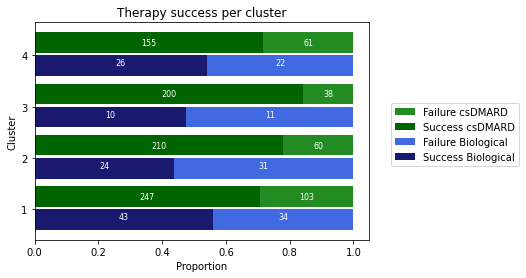

In [71]:
# Define Data

df = pd.DataFrame(dict(
    x1=np.array(l_csDMARD_succes) /np.array(l_csDMARD_total), # success conventional
    x2=[1,1,1,1] , # total convential
    x3=np.array(l_biological_succes)/np.array(l_biological_total), # success biological
    x4=[1,1,1,1])) # total biological

plt.barh([1+0.05, 2+0.05, 3+0.05, 4+0.05], df.x2, align='edge', height=0.40, color='forestgreen')
plt.barh([1+0.05, 2+0.05, 3+0.05, 4+0.05], df.x1, align='edge', height=0.40, color='darkgreen' )
plt.barh([1, 2, 3, 4], df.x4, align='edge', height=- 0.40,color='royalblue')
plt.barh([1, 2, 3, 4], df.x3, align='edge', height=- 0.40,  color='midnightblue')

plt.title('Therapy success per cluster')
plt.ylabel("Cluster")
plt.xlabel("Proportion")
plt.legend([ "Failure csDMARD",  "Success csDMARD", "Failure Biological","Success Biological"], bbox_to_anchor=(1.05, 0.65))

# Add text
for j, (q1, pc1) in enumerate(zip(df.iloc[:, 0:]['x1'],df['x1'])):
    print(i)
    i = j + 1
    raw_q1, raw_pc1 = list(zip(df_raw.iloc[:, 0:]['x1'],df_raw['x1']))[j]
    
    # also get bDMARD info
    (q2, pc2 ) = list(zip(df.iloc[:, 0:]['x3'],df['x3']))[j]
    raw_q2, raw_pc2 = list(zip(df_raw.iloc[:, 0:]['x3'],df_raw['x3']))[j]
    
    # also get failure info
    fail_q1, _ = list(zip(df_raw.iloc[:, 0:]['x2'],df_raw['x2']))[j]
    fail_q2, _ = list(zip(df_raw.iloc[:, 0:]['x4'],df_raw['x4']))[j]
    
    
    # conventional DMARD
    print(raw_q1,raw_pc1)
    if np.round(pc1 * 100, 1) > 5: # Threshold = 5%
        plt.text(q1 - pc1 / 2, i+ 0.2,  str(raw_q1),
            ha = 'center', rotation = 0, fontsize = 8, color='white')
    if np.round(pc1 * 100, 1) > 5: # Failure
        print('y')
        plt.text(q1 + (fail_q1/(fail_q1+raw_q1)) /2, i+ 0.2,  str(fail_q1),
            ha = 'center', rotation = 0, fontsize = 8, color='white')
    
    # Biological DMARD
    if np.round(pc2 * 100, 1) > 5: # Threshold = 5%
        plt.text(q2 - pc2 / 2, i- 0.2,  str(raw_q2),
            ha = 'center', rotation = 0, fontsize = 8, color='white')
    if np.round(pc2 * 100, 1) > 5: # Failure
        plt.text(q2 + (fail_q2/(fail_q2+raw_q2)) /2, i- 0.2,  str(fail_q2),
            ha = 'center', rotation = 0, fontsize = 8, color='white')

plt.yticks(np.arange(1, 5, step=1))
#plt.legend(['Conventional DMARD','Biological DMARD'],loc=(1.04,0), ncol= 1)
print(df_patientBased.groupby(['PhenoGraph_clusters'])[drug_name].value_counts(normalize=False))   

### #4.3 Which Biological drugs were succesfull (ignore exposure)
We ignore the patients that tried- but failed on the biologicals

<ipython-input-22-43021b96701b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub['FinalBiological'] = df_sub['FinalDrug'].apply(lambda x : ' & '.join(re.findall('('+ '|'.join(l_biological) + ')',x)))


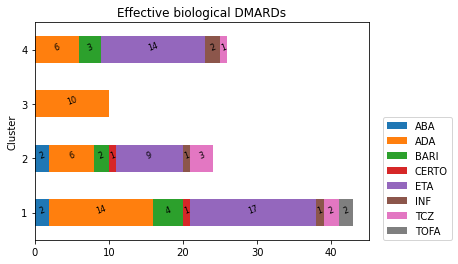

In [22]:
# importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

NORMALIZE = False

df_sub = df_biological[df_biological['Succes_biologicalDMARD']==True]

# Extract the biological
df_sub['FinalBiological'] = df_sub['FinalDrug'].apply(lambda x : ' & '.join(re.findall('('+ '|'.join(l_biological) + ')',x)))

df_agg = df_sub.groupby(['Cluster'])['FinalBiological'].value_counts(normalize=NORMALIZE).unstack().fillna(0)




# plot a Stacked Bar Chart using matplotlib
df_agg.plot(
kind = 'barh',
stacked = True,
title = 'Effective biological DMARDs',
mark_right = True) # , cmap=newcmp


for n in df_agg:
    for i, (cs, pc) in enumerate(zip(df_agg.iloc[:, 0:].cumsum(1)[n],df_agg[n])):
        if np.round(pc * 100, 1) > 5: # Threshold = 5%
            if NORMALIZE:
                plt.text(cs - pc / 2, i, str(np.round(pc * 100, 1)) + '%',
                    ha = 'center', rotation = 20, fontsize = 8)
            else :
                plt.text(cs - pc / 2, i, str(int(pc)),
                    ha = 'center', rotation = 20, fontsize = 8)
plt.legend(loc=(1.04,0), ncol= 1)

### #4.4 Zoom into a specific drug (e.g. ETA)

 Quantify the number of times ETA was prescribed

In [23]:
df

,x1,x2,x3,x4
0,0.705714,1,0.558442,1
1,0.777778,1,0.436364,1
2,0.840336,1,0.476190,1
3,0.717593,1,0.541667,1


,Succes,Failure
1,17,19
2,9,17
3,0,5
4,14,9


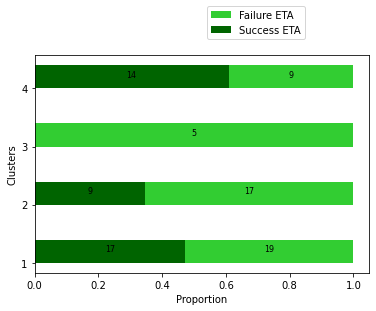

In [24]:
drug = 'ETA'

l_drug_succes = [len(df_relevant[((df_relevant['Cluster']==i) & (df_relevant['Exposed_to_%s' % (drug)]=='1')  & (df_relevant['FinalDrug'].str.contains(drug)) & (df_relevant['FinalTime']>364))]) for i in range(1,5)]
l_drug_failure = [len(df_relevant[((df_relevant['Cluster']==i) & (df_relevant['Exposed_to_%s' % (drug)]=='1') & ((~df_relevant['FinalDrug'].str.contains(drug)) | (df_relevant['FinalTime']<365)))]) for i in range(1,5)]

l_drug_total = list(np.array(l_drug_failure) + np.array(l_drug_succes))

df_drug_results = pd.DataFrame( dict(
    Succes=np.array(l_drug_succes), # success conventional
    Failure=np.array(l_drug_failure) )) # total convential
df_drug_results.index =[1,2,3,4]

# Define Data

df = pd.DataFrame(dict(
    x1=np.array(l_drug_succes) /np.array(l_drug_total), # success conventional
    x2=[1,1,1,1] )) # total biological

plt.barh( ['1', '2', '3', '4'], df.x2, align='edge', height=0.4, color='limegreen')
plt.barh(['1', '2', '3', '4'], df.x1, align='edge', height=0.4, color='darkgreen' )

#plt.yticks(['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])
plt.ylabel("Clusters")
plt.xlabel("Proportion")
plt.legend([ "Failure %s" % (drug),  "Success %s" % (drug)], bbox_to_anchor=(0.5, 1.05))


for i, (cs, pc) in enumerate(zip(df.iloc[:, 0:].cumsum(1)['x1'],df['x1'])):
    raw_q1, raw_pc1 = list(zip(df_drug_results.iloc[:, 0:]['Succes'],df_drug_results['Succes']))[i]
    raw_q2, raw_pc2 = list(zip(df_drug_results.iloc[:, 0:]['Failure'],df_drug_results['Failure']))[i]
    if np.round(pc * 100, 1) > 5: # Threshold = 5%
        plt.text(cs - pc / 2, i+ 0.2, str(raw_q1),
            ha = 'center', rotation = 0, fontsize = 8)
    if np.round((1-pc) * 100, 1) > 5: # Failure
        plt.text(pc + (raw_q2/(raw_q1+raw_q2)) /2, i+ 0.2,  str(raw_q2),
            ha = 'center', rotation = 0, fontsize = 8, color='black')

df_drug_results

#### 4.4.1 Look at exposure of ETA

PhenoGraph_clusters  ETA
1                    0      314
                     1       36
2                    0      244
                     1       26
3                    0      233
                     1        5
4                    0      193
                     1       23
Name: ETA, dtype: int64


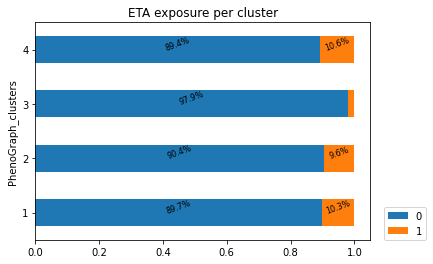

In [25]:
drug_name = 'ETA'

def isDrugPresent(row, drug):
    if row['All_prescriptions'] == row['All_prescriptions']: # check if not nan
        if drug in row['All_prescriptions']:
            return 1
        else :
            return 0
    else :
        return np.nan # return nan

l_drug = ['MTX', 'TCZ', 'HQL', 'ADA', 'HQL',
    'LEF', 'SSZ', 'CERTO', 'ABA', 'ETA',  
    'BARI','RTX', 'AZA', 'GOUD', 'INF',
      'TOFA']
    
for drug in l_drug:
    df_patientBased[drug] = df_patientBased.apply(lambda x : isDrugPresent(x, drug), axis=1)
    

# Count unique physicians per cluster
df_drug_agg = df_patientBased.groupby(['PhenoGraph_clusters'])[drug_name].value_counts(normalize=True).unstack().fillna(0)

# Create Palette
rainbow = cm.get_cmap('hsv', 80)
newcolors = rainbow(np.linspace(0, 1, 80))
newcmp = ListedColormap(newcolors)

# Very simple one-liner using our agg_tips DataFrame.
df_drug_agg.plot(
kind = 'barh',
stacked = True,
title = '%s exposure per cluster' % drug_name,
#title = 'Final Drug Stacked Bar Graph (Top 5)',
mark_right = True) # , cmap=newcmp

# Just add a title and rotate the x-axis labels to be horizontal.
plt.xticks(rotation=0, ha='center')
plt.legend(loc=(1.04,0), ncol= 3)

for n in df_drug_agg:
    for i, (cs, pc) in enumerate(zip(df_drug_agg.iloc[:, 0:].cumsum(1)[n],df_drug_agg[n])):
        if np.round(pc * 100, 1) > 5: # Threshold = 5%
            plt.text(cs - pc / 2, i, str(np.round(pc * 100, 1)) + '%',
                ha = 'center', rotation = 20, fontsize = 8)
plt.legend(loc=(1.04,0), ncol= 1)
print(df_patientBased.groupby(['PhenoGraph_clusters'])[drug_name].value_counts(normalize=False))    

#### 4.4.2 Zoom into specific drug (Adalimumab)

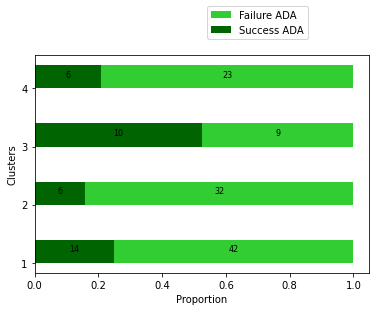

In [26]:
drug = 'ADA'

l_drug_succes = [len(df_relevant[((df_relevant['Cluster']==i) & (df_relevant['Exposed_to_%s' % (drug)]=='1')  & (df_relevant['FinalDrug'].str.contains(drug)) & (df_relevant['FinalTime']>364))]) for i in range(1,5)]
l_drug_failure = [len(df_relevant[((df_relevant['Cluster']==i) & (df_relevant['Exposed_to_%s' % (drug)]=='1') & ((~df_relevant['FinalDrug'].str.contains(drug)) | (df_relevant['FinalTime']<365)))]) for i in range(1,5)]

l_drug_total = list(np.array(l_drug_failure) + np.array(l_drug_succes))

df_drug_results = pd.DataFrame( dict(
    Succes=np.array(l_drug_succes), # success conventional
    Failure=np.array(l_drug_failure) )) # total convential
df_drug_results.index =[1,2,3,4]

# Define Data

df = pd.DataFrame(dict(
    x1=np.array(l_drug_succes) /np.array(l_drug_total), # success conventional
    x2=[1,1,1,1] )) # total biological

plt.barh( ['1', '2', '3', '4'], df.x2, align='edge', height=0.4, color='limegreen')
plt.barh(['1', '2', '3', '4'], df.x1, align='edge', height=0.4, color='darkgreen' )

#plt.yticks(['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])
plt.ylabel("Clusters")
plt.xlabel("Proportion")
plt.legend([ "Failure %s" % (drug),  "Success %s" % (drug)], bbox_to_anchor=(0.5, 1.05))

for i, (cs, pc) in enumerate(zip(df.iloc[:, 0:].cumsum(1)['x1'],df['x1'])):
    raw_q1, raw_pc1 = list(zip(df_drug_results.iloc[:, 0:]['Succes'],df_drug_results['Succes']))[i]
    raw_q2, raw_pc2 = list(zip(df_drug_results.iloc[:, 0:]['Failure'],df_drug_results['Failure']))[i]
    if np.round(pc * 100, 1) > 5: # Threshold = 5%
        plt.text(cs - pc / 2, i+ 0.2, str(raw_q1),
            ha = 'center', rotation = 0, fontsize = 8)
    if np.round((1-pc) * 100, 1) > 5: # Failure
        plt.text(pc + (raw_q2/(raw_q1+raw_q2)) /2, i+ 0.2,  str(raw_q2),
            ha = 'center', rotation = 0, fontsize = 8, color='black')


## #5 Visualize effective Therapies per cluster


In [28]:
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import pandas as pd
import plotly.graph_objects as go

d_acronym = {'ABATACEPT' : 'ABA', 'ADALIMUMAB' : 'ADA', 'AZATHIOPRINE' : 'AZA','AUROTHIOBARNSTEENZUUR (DI-NA-ZOUT)' : 'GOUD', 'BARICITINIB': 'BARI', 'CERTOLIZUMAB PEGOL' :'CERTO',  'ETANERCEPT' : 'ETA', 'GOLIMUMAB' : 'GOL', 'HYDROXYCHLOROQUINE':'HQL', 'INFLIXIMAB' : 'INF', 'LEFLUNOMIDE' : 'LEF', 'METHOTREXAAT' : 'MTX', 'RITUXIMAB' : 'RTX', 'SULFASALAZINE' : 'SSZ', 'TOCILIZUMAB' : 'TCZ', 'TOFACITINIB' : 'TOFA'}

# Import meta data
df_ult = pd.read_csv('../new_data/offshoots/df_ehr_scaled_withOutcome_woCounts.csv', sep='|')

# Import drug data  
df_drug = pd.read_csv('../new_data/7_final/EffectiveDrugInformation.csv', sep=',')
d_drug = dict(zip(df_drug.pseudoId, df_drug.Drug))
d_time_on_drug = dict(zip(df_drug.pseudoId, df_drug.Time))
df_ult['FinalDrug'] = df_ult['pseudoId'].apply(lambda x: d_drug[x]).astype(str) 
df_ult['FinalTime'] = df_ult['pseudoId'].apply(lambda x: d_time_on_drug[x]).astype(str) 

# Sort drugs alphabetically & use acronyms
df_ult['FinalDrug'] = df_ult['FinalDrug'].apply(lambda x : ' & '.join([d_acronym[i]  if i in d_acronym.keys() else i for i in sorted(x.split(' & '))]))

# Only select those where they stay on a drug longer than a year
df_ult['FinalTime'] = df_ult['FinalTime'].astype(float)

In [29]:
df_results.to_csv('../new_data/6_medication/Summary_Drug_Effectiveness.csv')

### #5.1 Check final drug that people end with

### #5.1 Visualize final drug for clusters in bar chart

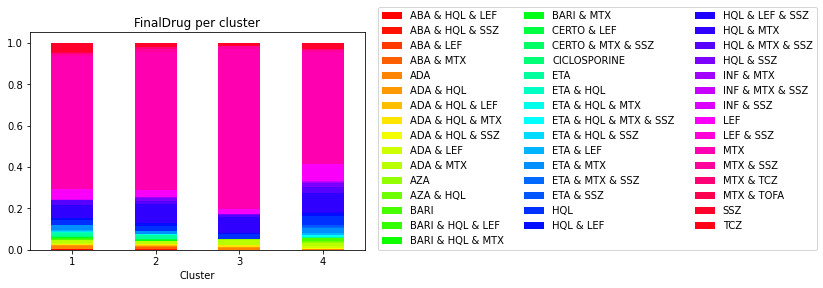

In [42]:
# Count unique physicians per cluster

#df_relevant = df_ult[df_ult['MTX-starter']==True].copy()
df_agg = df_relevant.groupby(['Cluster'])['FinalDrug'].value_counts(normalize=True).unstack().fillna(0)
df_agg_raw = df_relevant.groupby(['Cluster'])['FinalDrug'].value_counts().unstack().fillna(0)


# Create Palette
rainbow = cm.get_cmap('hsv', 80)
newcolors = rainbow(np.linspace(0, 1, 80))
newcmp = ListedColormap(newcolors)

# Very simple one-liner using our agg_tips DataFrame.
df_agg.plot(kind='bar', stacked=True, cmap=newcmp)

# Just add a title and rotate the x-axis labels to be horizontal.
plt.title('FinalDrug per cluster')
plt.xticks(rotation=0, ha='center')
plt.legend(loc=(1.04,0), ncol= 3)



### #5.2 Time it takes to reach final (effective) drug prescription 

Text(0, 0.5, 'Time till effective drug is found')

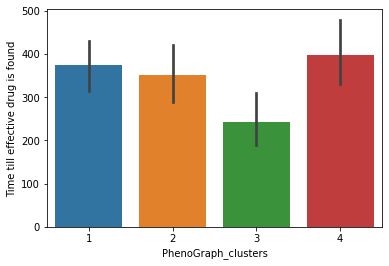

In [34]:
import seaborn as sns
import pandas as pd

df_med = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/7_final/EffectiveDrugInformation.csv')

df_cluster = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/7_final/MMAE_clustering_270_Stability.csv') # all_data_MAUI_clustering_90_2

df_cluster['pseudoId'] = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/5_clustering/df_metadata_keys.csv')['pseudoId']
df_cluster['PhenoGraph_clusters'] = df_cluster['PhenoGraph_clusters'] +1

# Response
df_response = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/7_final/SummaryResponseTable_MMAE3.csv', sep=';') 

# Add the actual patient id & pseudoId to the metadata (by matching on the index)
df_cluster = pd.merge(df_cluster, df_response, on='pseudoId')

df_med = pd.merge(df_med, df_cluster[['pseudoId', 'PhenoGraph_clusters', 'totalFollowUp', 'MTX-starter']], on='pseudoId')

# Draw a nested boxplot to show bills by day and time
ax = sns.barplot(x="PhenoGraph_clusters", y="Start",
            data=df_med) 
ax.set_ylabel('Time till effective drug is found')

#### #5.5.1. Print actual numbers 

In [35]:
# Count unique physicians per cluster
len(df_med[((df_med['PhenoGraph_clusters']==4) & (df_med['Drug']=='ETANERCEPT')  & (df_med['MTX-starter']==1))])

1

In [36]:
# Count unique physicians per cluster
len(df_med[((df_med['PhenoGraph_clusters']==4) & (df_med['Drug'].str.contains('ETANERCEPT')) & (df_med['MTX-starter']==1))])#['Drug']

14

### #5.3 Average follow up time of patients that start with MTX

Nr of patients that start with baseline drug (MTX): 915


Text(0, 0.5, 'Follow up')

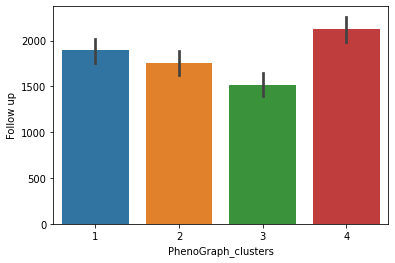

In [37]:
l_final = df_med[df_med['Time']>364]['pseudoId'].unique()
df_sub = df_med[df_med['pseudoId'].isin(l_final)].copy()
df_sub = df_sub[df_sub['MTX-starter']==1]
print('Nr of patients that start with baseline drug (MTX):', len(df_sub))

# Draw a nested boxplot to show bills by day and time
ax = sns.barplot(x="PhenoGraph_clusters", y="totalFollowUp",
            data=df_sub) 
ax.set_ylabel('Follow up')

### How does the survival data compare to the Drug Information (positive validation)

In [ ]:
import pandas as pd
df_ult = pd.read_csv('../new_data/offshoots/df_ehr_scaled_withOutcome_woCounts.csv', sep='|')
d_event = dict(zip(df_ult.pseudoId, df_ult.event_1y))
d_time2event = dict(zip(df_ult.pseudoId, df_ult.time))

df_all_drug = pd.read_csv('../new_data/7_final/DrugInformation.csv', sep=',')
df_all_drug = df_all_drug[df_all_drug['pseudoId'].isin(df_ult['pseudoId'])]
df_all_drug['Event_1y']  =  df_all_drug['pseudoId'].apply(lambda x : d_event[x])
df_all_drug['Time_to_event']  =  df_all_drug['pseudoId'].apply(lambda x : d_time2event[x])
df_all_drug

## ToDo: Make table

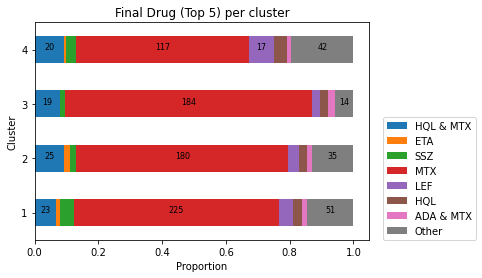

In [70]:
# importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ONLY_TOP = True
TOP = 5

# Top 5 for each
l_top_features = list(df_agg.T.nlargest(TOP, 1).index)
for i in range(1, len(df_agg)):
    l_top_features.extend(list(df_agg.T.nlargest(TOP, i).index))
l_top_features = list(set(l_top_features))

# Only display top features

if ONLY_TOP:
    d_translate = {}
    df_sub = df_agg.copy()
    df_sub2 = df_agg_raw.copy()
    df_sub['Other'] = df_sub[[i for i in df_sub.columns if i not in l_top_features]].sum(axis=1)
    df_sub2['Other'] = df_sub2[[i for i in df_sub2.columns if i not in l_top_features]].sum(axis=1)
    
    l_top_features.append('Other')
    df_sub = df_sub[l_top_features]
    df_sub2 = df_sub2[l_top_features]
    
# plot a Stacked Bar Chart using matplotlib
df_sub.plot(
kind = 'barh',
stacked = True,
title = 'Final Drug (Top 5) per cluster',
mark_right = True,
xlabel='Proportion') # , cmap=newcmp

for n in df_sub:
    for i, (cs, pc) in enumerate(zip(df_sub.iloc[:, 0:].cumsum(1)[n],df_sub[n])):
        raw_cs, raw_pc = list(zip(df_sub2.iloc[:, 0:][n],df_sub2[n]))[i]
        #print(raw_cs)
        if np.round(pc * 100, 1) > 5: # Threshold = 5%
            plt.text(cs - pc / 2, i, str(round(raw_pc)),
                ha = 'center', rotation = 0, fontsize = 8)
plt.legend(loc=(1.04,0), ncol= 1)

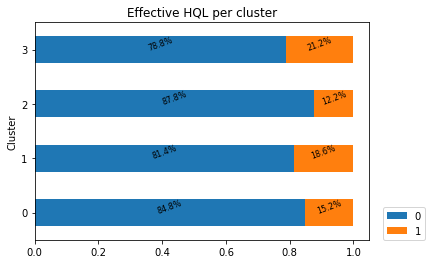

In [50]:
# Count unique physicians per cluster
drug_name = 'HQL'
df_drug_agg = df_relevant.groupby(['Cluster'])[drug_name].value_counts(normalize=True).unstack().fillna(0)

# Create Palette
rainbow = cm.get_cmap('hsv', 80)
newcolors = rainbow(np.linspace(0, 1, 80))
newcmp = ListedColormap(newcolors)

# Very simple one-liner using our agg_tips DataFrame.
df_drug_agg.plot(
kind = 'barh',
stacked = True,
title = 'Effective %s per cluster' % (drug_name),
#title = 'Final Drug Stacked Bar Graph (Top 5)',
mark_right = True) # , cmap=newcmp

# Just add a title and rotate the x-axis labels to be horizontal.
plt.xticks(rotation=0, ha='center')
plt.legend(loc=(1.04,0), ncol= 3)

for n in df_drug_agg:
    for i, (cs, pc) in enumerate(zip(df_drug_agg.iloc[:, 0:].cumsum(1)[n],df_drug_agg[n])):
        if np.round(pc * 100, 1) > 5: # Threshold = 5%
            plt.text(cs - pc / 2, i, str(np.round(pc * 100, 1)) + '%',
                ha = 'center', rotation = 20, fontsize = 8)
plt.legend(loc=(1.04,0), ncol= 1)

# Import survival data and append initial DAS
So Marc can assess the predictive value of the DAS

#### See step #7.2.3 from Notebook step 7

## Learn predictive Model over 1 year

In [46]:
import pandas as pd
df_meta = pd.read_csv('../new_data/offshoots/df_ehr_scaled_withOutcome_woCounts.csv', sep='|')

df_subset = df_meta.copy()
df_subset = df_subset[df_subset['MTX-starter']==True]

X = df_subset.values
y = df_subset['event_1y']

### Make dummy variables for clusters

In [48]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Perform OHE
df_subset['Cluster1'] = np.where(df_subset['Cluster']==1,1,0)
df_subset['Cluster2'] = np.where(df_subset['Cluster']==2,1,0)
df_subset['Cluster3'] = np.where(df_subset['Cluster']==3,1,0)
df_subset['Cluster4'] = np.where(df_subset['Cluster']==4,1,0)

def get_proba(row):
    cluster_id = row['Cluster']
    return row['PROBA_CLUSTER%s' % (cluster_id)]
# Calculate probability
df_subset['PROBABILITY'] = df_subset.apply(lambda x: get_proba(x), axis=1)
df_subset.to_csv('../new_data/offshoots/df_ehr_scaled_withOutcome_woCounts2.csv', sep='|', index=False)

## Project Rx usage on UMAP

<AxesSubplot:xlabel='PhenoGraph_clusters', ylabel='totalFollowUp'>

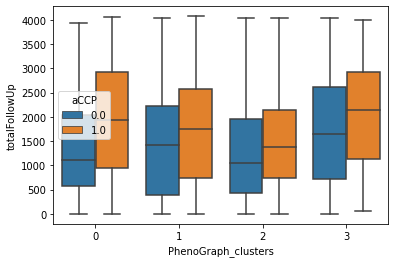

In [35]:
import pandas as pd
import seaborn as sns

# Latent feature space (a.k.a. Factors from MOFA)
metadata = pd.read_csv(r'../filters/RA_patients_AllNP_Characteristics_symptomDur.csv', sep='|')
df_clust =  pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/7_final/MMAE_clustering_270_Stability.csv')
df_clust['PhenoGraph_clusters'] = df_clust['PhenoGraph_clusters'].copy()
d_fu = dict(zip(metadata['pseudoId'], metadata['totalFollowUp']))

df_clust[df_clust['']]

df_clust['totalFollowUp'] = df_clust['pseudoId'].apply(lambda x : d_fu[x])
#metadata = pd.read_csv('../new_data/5_clustering/df_metadata.csv')
#col for col in df_clust.columns if 'llow' in col]

#metadata['totalFollowUp']

sns.boxplot(data=df_clust, x="PhenoGraph_clusters", y="totalFollowUp", hue="aCCP")

In [6]:
import pandas as pd
import numpy as np

import sys

sys.path.append(r'../src/1_emr_scripts')
from sklearn.manifold import TSNE
import umap 
import importlib as imp
import Visualization as func

SEED = 20221212

EMBEDDING_SPACE = 'MMAE_embedding'
l_drug = ['METHOTREXAAT', 'PREDNISOLON', 'HYDROXYCHLOROQUINE',
       'SULFASALAZINE', 'ADALIMUMAB', 'METHYLPREDNISOLON', 'LEFLUNOMIDE',
       'ETANERCEPT', 'RITUXIMAB', 'BARICITINIB', 'ABATACEPT',
       'TOFACITINIB', 'AUROTHIOBARNSTEENZUUR (DI-NA-ZOUT)', 'INFLIXIMAB',
       'AZATHIOPRINE', 'TOCILIZUMAB', 'GOLIMUMAB', 'CYCLOFOSFAMIDE',
       'CICLOSPORINE', 'CERTOLIZUMAB PEGOL', 'ANAKINRA']

def isDrugPresent(row, drug):
    if row['Drug'] == row['Drug'] and row['MTX-starter']==True:
        if drug in row['Drug']:
            return 1
        else :
            return 0
    else :
        return np.nan # return nan
# ['Drug']

# Latent feature space (a.k.a. Factors from MOFA)
metadata = pd.read_csv('../new_data/5_clustering/df_metadata.csv')
Z = pd.read_csv('../results/embedding/%s.csv' % EMBEDDING_SPACE) # maui_embedding_3.csv
Z = Z[Z.columns[4:]]

# Use default dim reduction techniques
fit1 = TSNE(random_state=SEED, n_components=2, perplexity=30, metric='minkowski').fit_transform(Z.values)
fit2 = umap.UMAP(random_state=SEED+233,metric='minkowski', n_neighbors=7).fit(Z.values).embedding_ # 144 or 113 / 203
    
metadata = pd.read_csv('../new_data/7_final/MMAE_clustering_270_Stability.csv', index_col=0)

df_med = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/7_final/EffectiveDrugInformation.csv')

df_ult = pd.read_csv('../new_data/offshoots/df_ehr_scaled_withOutcome_woCounts.csv', sep='|')

metadata = metadata.merge(df_med[['pseudoId', 'Drug']], on='pseudoId', how='left')

metadata = metadata.merge(df_ult[['pseudoId', 'MTX-starter']], on='pseudoId', how='left')

for drug in l_drug:
    metadata[drug] = metadata.apply(lambda x : isDrugPresent(x, drug), axis=1)


# Create dummy variables from mannequin data
metadata = metadata.join(pd.get_dummies(metadata.Drug, prefix='Drug'))

# fill NaN with 0.0
#metadata = metadata.fillna(0.0)
metadata.head()

# get categoric
df_categoric= pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/5_clustering/df_categoric.csv', sep=',')
l_cat = df_categoric.columns

func.visualize_umap_bokeh_na_2(fit1, metadata, list(metadata.columns), l_binary=l_cat, patient_id='pseudoId', cluster_id='PhenoGraph_clusters', title='MMAE_Rx_270_TSNE')
func.visualize_umap_bokeh_na_2(fit2, metadata, list(metadata.columns), l_binary=l_cat, patient_id='pseudoId', cluster_id='PhenoGraph_clusters', title='MMAE_Rx_270_UMAP')

/exports/reum/tdmaarseveen/convae_architecture/envs/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/exports/reum/tdmaarseveen/convae_architecture/envs/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/exports/reum/tdmaarseveen/convae_architecture/envs/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


1387 1387
0 []

UMAP figure saved under location: TSNE/Baseline_MMAE_Rx_270_TSNE.html
1387 1387
0 []

UMAP figure saved under location: TSNE/Baseline_MMAE_Rx_270_UMAP.html
